<a href="https://colab.research.google.com/github/pauljohn99/ML-learnings/blob/main/mouthAnotationLoaded.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pycocotools --quiet
!git clone https://github.com/pytorch/vision.git
!git checkout v0.3.0
!cp vision/references/detection/utils.py ./
!cp vision/references/detection/transforms.py ./
!cp vision/references/detection/coco_eval.py ./
!cp vision/references/detection/engine.py ./
!cp vision/references/detection/coco_utils.py ./

Cloning into 'vision'...
remote: Enumerating objects: 308593, done.
remote: Counting objects: 100% (3350/3350), done.
remote: Compressing objects: 100% (269/269), done.
remote: Total 308593 (delta 3107), reused 3301 (delta 3070), pack-reused 305243
Receiving objects: 100% (308593/308593), 629.61 MiB | 17.29 MiB/s, done.
Resolving deltas: 100% (283245/283245), done.
fatal: not a git repository (or any of the parent directories): .git


In [2]:
import os
import random
import numpy as np
import pandas as pd
# for ignoring warnings
import warnings
warnings.filterwarnings('ignore')

# We will be reading images using OpenCV
import cv2

# xml library for parsing xml files
from xml.etree import ElementTree as et

# matplotlib for visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# torchvision libraries
import torch
import torchvision
from torchvision import transforms as torchtrans  
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# these are the helper libraries imported.
from engine import train_one_epoch, evaluate
import utils
import transforms as T

# for image augmentations
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
test_dir = '/content/drive/MyDrive/mouthOpenClosed/closed'

In [5]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [6]:
model = torch.load("/content/mouth-model.pt",map_location=torch.device('cpu'))

In [7]:
def apply_nms(orig_prediction, iou_thresh=0.3):
    
    # torchvision returns the indices of the bboxes to keep
    keep = torchvision.ops.nms(orig_prediction['boxes'], orig_prediction['scores'], iou_thresh)
    
    final_prediction = orig_prediction
    final_prediction['boxes'] = final_prediction['boxes'][keep]
    final_prediction['scores'] = final_prediction['scores'][keep]
    final_prediction['labels'] = final_prediction['labels'][keep]
    
    return final_prediction

# function to convert a torchtensor back to PIL image
def torch_to_pil(img):
    return torchtrans.ToPILImage()(img).convert('RGB')

In [8]:
class MouthImagesDataset(torch.utils.data.Dataset):

    def __init__(self, files_dir, width, height, transforms=None):
        self.transforms = transforms
        self.files_dir = files_dir
        self.height = height
        self.width = width
        
        # sorting the images for consistency
        # To get images, the extension of the filename is checked to be jpg
        self.imgs = [image for image in sorted(os.listdir(files_dir))
                        if image[-4:]=='.jpg']
        
          
        # classes: 0 index is reserved for background
        self.classes = [_,'mouth']

    def __getitem__(self, idx):

        img_name = self.imgs[idx]
        image_path = os.path.join(self.files_dir, img_name)

        # reading the images and converting them to correct size and color    
        img = cv2.imread(image_path)
       
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img_res = cv2.resize(img_rgb, (self.width, self.height), cv2.INTER_AREA)
        # diving by 255
        img_res /= 255.0
#         # annotation file
#         annot_filename = img_name[:-4] + '.xml'
#         annot_file_path = os.path.join(self.files_dir, annot_filename)
        
#         boxes = []
#         labels = []
#         tree = et.parse(annot_file_path)
#         root = tree.getroot()
        
#         # cv2 image gives size as height x width
#         wt = img.shape[1]
#         ht = img.shape[0]
        
#         # box coordinates for xml files are extracted and corrected for image size given
#         for member in root.findall('object'):
#             labels.append(self.classes.index(member.find('name').text))
            
#             # bounding box
#             xmin = int(member.find('bndbox').find('xmin').text)
#             xmax = int(member.find('bndbox').find('xmax').text)
            
#             ymin = int(member.find('bndbox').find('ymin').text)
#             ymax = int(member.find('bndbox').find('ymax').text)
            
            
#             xmin_corr = (xmin/wt)*self.width
#             xmax_corr = (xmax/wt)*self.width
#             ymin_corr = (ymin/ht)*self.height
#             ymax_corr = (ymax/ht)*self.height
            
#             boxes.append([xmin_corr, ymin_corr, xmax_corr, ymax_corr])
        
#         # convert boxes into a torch.Tensor
#         boxes = torch.as_tensor(boxes, dtype=torch.float32)
        
#         # getting the areas of the boxes
#         area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

#         # suppose all instances are not crowd
#         iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
        
#         labels = torch.as_tensor(labels, dtype=torch.int64)


#         target = {}
#         target["boxes"] = boxes
#         target["labels"] = labels
#         target["area"] = area
#         target["iscrowd"] = iscrowd
#         # image_id
#         image_id = torch.tensor([idx])
#         target["image_id"] = image_id


        if self.transforms:
            
            sample = self.transforms(image = img_res,
                                     )
            
            img_res = sample['image']
#             target['boxes'] = torch.Tensor(sample['bboxes'])
            
            
            
        # return img_res, target
        return img_res
    def __len__(self):
        return len(self.imgs)




In [ ]:
# # Send train=True fro training transforms and False for val/test transforms
# def get_transform(train):
    
#     if train:
#         return A.Compose([
#                             A.HorizontalFlip(0.5),
#                      # ToTensorV2 converts image to pytorch tensor without div by 255
#                             ToTensorV2(p=1.0) 
#                         ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
#     else:
#         return A.Compose([
#                             ToTensorV2(p=1.0)
#                         ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [12]:
def plot_img_bbox(img, target):
    # plot the image and bboxes
    # Bounding boxes are defined as follows: x-min y-min width height
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(5,5)
    a.imshow(img)
    for box in (target['boxes']):
        x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = patches.Rectangle((x, y),
                                 width, height,
                                 linewidth = 2,
                                 edgecolor = 'g',
                                 facecolor = 'none')

        # Draw the bounding box on top of the image
        print(type(rect))
        a.add_patch(rect)
    plt.show()
    
# plotting the image with bboxes. Feel free to change the index
img, target = dataset[0]
plot_img_bbox(img, target)

NameError: ignored

MODEL OUTPUT

0.9958305
{'boxes': tensor([[146.6495, 183.5336, 371.9935, 277.9096]]), 'labels': tensor([1]), 'scores': tensor([0.9958])}
[146.64946 183.53357 371.9935  277.9096 ]
{'boxes': array([[146.64946, 183.53357, 371.9935 , 277.9096 ]], dtype=float32)}
<class 'matplotlib.patches.Rectangle'>


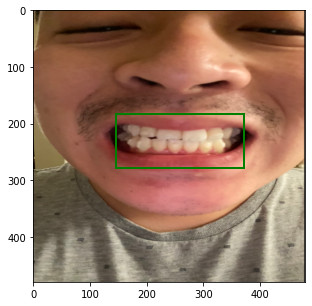

MODEL OUTPUT

0.9833708
{'boxes': tensor([[ 59.0388, 154.1401, 387.9279, 308.9462]]), 'labels': tensor([1]), 'scores': tensor([0.9834])}
[ 59.038773 154.14006  387.92786  308.94623 ]
{'boxes': array([[ 59.038773, 154.14006 , 387.92786 , 308.94623 ]], dtype=float32)}
<class 'matplotlib.patches.Rectangle'>


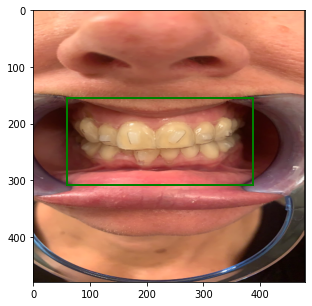

MODEL OUTPUT

0.9815403
{'boxes': tensor([[140.8771, 194.2705, 355.7788, 299.2982],
        [479.9815,   0.0000, 480.0000,   5.9403]]), 'labels': tensor([1, 1]), 'scores': tensor([0.9815, 0.2080])}
[140.87712 194.27048 355.77884 299.29816]
{'boxes': array([[140.87712, 194.27048, 355.77884, 299.29816]], dtype=float32)}
<class 'matplotlib.patches.Rectangle'>


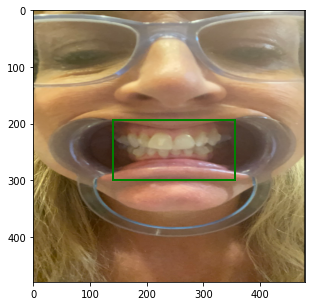

In [14]:
test_dataset = MouthImagesDataset(test_dir, 480, 480, ToTensorV2(p=1.0))
mouth_anotation(test_dataset)

In [13]:
def mouth_anotation(test_dataset):
 test_dataset = MouthImagesDataset(test_dir, 480, 480, ToTensorV2(p=1.0))
# pick one image from the test set
 y=len(test_dataset)
 model.eval()
 for i in range(3):
  img= test_dataset[i]
  
#  # put the model in evaluation mode
#  model.eval()
  with torch.no_grad():
    prediction = model([img.to(device)])[0]
  i=i+1  
#  print('EXPECTED OUTPUT\n')
#  plot_img_bbox(torch_to_pil(img), target)
  print('MODEL OUTPUT\n')
  nms_prediction = apply_nms(prediction, iou_thresh=0.1)
#  print(nms_prediction['scores'])
#  print(nms_prediction['scores'].detach().cpu().numpy())
  p=nms_prediction['scores'].detach().cpu().numpy()
  pr=np.argmax(p)
  x=max(p)
  print(x)
  print(nms_prediction)
  pred=np.reshape(nms_prediction['boxes'][pr].detach().cpu().numpy(), (-1, 4))
  print(pred[0])
  pred1={'boxes': pred}
  print(pred1)
#  print('NMS APPLIED MODEL OUTPUT')
  plot_img_bbox(torch_to_pil(img), pred1)

In [ ]:
# !pip install mediapipe

In [ ]:
# !pip install imageio-ffmpeg

In [ ]:
!pip3 install imageio==2.4.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# !pip install moviepy

In [ ]:
import logging
import math

import cv2

import numpy as np
import mediapipe as mp

from moviepy.editor import ImageClip, concatenate_videoclips, CompositeVideoClip
from moviepy.video.fx.all import crop




In [ ]:
# Detector Params
NUM_FACE = 1
MIN_DETECTION_CONFIDENCE = 0.05
MIN_TRACKING_CONFIDENCE = 0.05
# Load the face landmark model from mediapipe
mpFaceMesh = mp.solutions.face_mesh
faceMesh = mpFaceMesh.FaceMesh(max_num_faces=NUM_FACE, min_detection_confidence=MIN_DETECTION_CONFIDENCE, min_tracking_confidence=MIN_TRACKING_CONFIDENCE)
frames =("/content/drive/MyDrive/mouthOpenClosed/closed/1-closed.png") 
crop_smile(frames)

MODEL OUTPUT

0.99808526
{'boxes': tensor([[133.8947, 191.7812, 388.3915, 269.0995]]), 'labels': tensor([1]), 'scores': tensor([0.9981])}
[133.89473 191.78117 388.39148 269.09946]
MODEL OUTPUT

0.9956233
{'boxes': tensor([[ 27.7956, 154.8666, 407.4683, 307.5329]]), 'labels': tensor([1]), 'scores': tensor([0.9956])}
[ 27.795557 154.86656  407.4683   307.53293 ]
MODEL OUTPUT

0.9907189
{'boxes': tensor([[124.7398, 191.6214, 356.3762, 289.4250]]), 'labels': tensor([1]), 'scores': tensor([0.9907])}
[124.73984 191.62138 356.37616 289.42505]


In [ ]:
def create_video(frames, output_file="out.mp4"):
	if len(frames) < 2:
		logging.warning("Not enough frames to create video.")
		return (0, "Not enough frames to create video.")

	video_width = 1280
	video_height = 720

	# Crop images to smiles
	crop_coordinates = [crop_smile(i) for i in frames]

	# Add images
	imageclips = [ImageClip(m).set_duration(2).crossfadein(1).set_start(i) for i,m in enumerate(frames)]
	# Crop images
	imageclips = [crop(m, *crop_coordinates[i]) for i,m in enumerate(imageclips) if crop_coordinates[i] is not None]

	if len(imageclips) < 2:
		logging.warning("Not enough frames with teeth detected to create video.")
		return (0, "Not enough frames with teeth detected to create video.")

	# Resize to fit
	imageclips = [i.resize(video_height/i.size[0] if i.size[0] > i.size[1] else video_width/i.size[1]) for i in imageclips]
	# Re-position to center
	imageclips = [i.set_position("center") for i in imageclips]

	watermark = ImageClip("assets/watermark.png").set_duration(len(imageclips)+1).crossfadein(1).set_start(0)
	watermark = watermark.resize(video_width/(2*watermark.size[0]))
	watermark = watermark.set_position((0.4, 0.8), relative="true")

	imageclips.append(watermark)

	concat_clip = CompositeVideoClip(imageclips, size=(video_width,video_height))
	concat_clip.write_videofile(output_file, fps=24, codec="libx264")

	return (1, "Success")

def crop_smile(img_file):
	img = cv2.imread(img_file)
	padding_factor = 0.4
	sc = mouth_anotation(img)
	if sc is None:
		return None
	(x, y, w, h) = sc
	y = math.floor(y-padding_factor*h if (padding_factor*h <= y) else 0)
	x = math.floor(x-padding_factor*w if (padding_factor*w <= x) else 0)
	w = math.ceil(w*(1+2*padding_factor))
	h = math.ceil(h*(1+2*padding_factor))
	return (x, y, x+w, y+h)


def detect_smile(img):
	smile_img = img.copy()
	image_width = smile_img.shape[0]
	image_height = smile_img.shape[1]
	imgRGB = cv2.cvtColor(smile_img, cv2.COLOR_BGR2RGB)
	results = faceMesh.process(imgRGB)
	if results.multi_face_landmarks:
		faceLms = results.multi_face_landmarks[0]
		left_corner = (faceLms.landmark[61].x*image_width, faceLms.landmark[61].y*image_height)
		top_corner = (faceLms.landmark[0].x*image_width, faceLms.landmark[0].y*image_height)
		right_corner = (faceLms.landmark[291].x*image_width, faceLms.landmark[291].y*image_height)
		bottom_corner = (faceLms.landmark[17].x*image_width, faceLms.landmark[17].y*image_height)

		return (left_corner[0], top_corner[1], right_corner[0]-left_corner[0], bottom_corner[1]-top_corner[1])
	else:
		return None